# Checking a few things in STRING


The following questinos needs to be answered:

- [x] Are there non-human interactors?
    * No. all human
- [x] Ensembl protein ids needs to be mapped to target ids.
- [X] What is the largest number of interaction for a given target?
    * Indeed the a/b matrix is symmetric
    * without any score filter, the largest number interactinos for a target is 7600
    * Over 3000 genes have 1000+ interactions
    * with a 0.8 scores threshold, the larges number is: 
- [ ] Email Cinzia to make sure the methods mapping is removed.

In [1]:
import pandas as pd
import gzip
import json

stringfile = '/Users/dsuveges/project/issue-870_Import_STRING_db/9606.protein.links.detailed.v11.0.txt.gz'

string_df = pd.read_csv(stringfile, compression='infer', sep=' ')
string_df.head()

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167


In [6]:
string_df['A_taxid'], string_df['A_protid'] = zip(*string_df.protein1.str.split('.'))
string_df['B_taxid'], string_df['B_protid'] = zip(*string_df.protein2.str.split('.'))

string_df.head()

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,A_taxid,A_protid,B_taxid,B_protid
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,332,62,181,0,125,490,9606,ENSP00000000233,9606,ENSP00000272298
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,186,0,56,198,9606,ENSP00000000233,9606,ENSP00000253401
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,159,0,0,159,9606,ENSP00000000233,9606,ENSP00000401445
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,61,158,0,542,606,9606,ENSP00000000233,9606,ENSP00000418915
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,88,78,0,89,167,9606,ENSP00000000233,9606,ENSP00000327801


In [7]:
print(string_df.A_taxid.unique())
print(string_df.B_taxid.unique())

['9606']
['9606']


## Get enseml protein id -> gene id mapping

This information is read from the ensembl json file we have for the covid data

In [12]:
ensembl_json = '/Users/dsuveges/repositories/ot_covid19/temp/raw_files/ensembl.json'

gene_data = []
with open(ensembl_json) as f:
    for line in f:
        # Skipping non-protein coding genes:
        if 'ENSP' not in line:
            continue
            
        data = json.loads(line)
        gene_id = data['id']
        
        for transcript in data['transcripts']:
            if 'translations' not in transcript:
                continue
            
            for translation in transcript['translations']:
                prot_id = translation['id']
                gene_data.append({'gene_id': gene_id, 'prot_id': prot_id})
            
gene_df = pd.DataFrame(gene_data)
print(gene_df.head())
print(len(gene_df))

           gene_id          prot_id
0  ENSG00000224440  ENSP00000489806
1  ENSG00000135541  ENSP00000433864
2  ENSG00000135541  ENSP00000432167
3  ENSG00000135541  ENSP00000435710
4  ENSG00000135541  ENSP00000436071
111886


In [19]:
# Joining gene ids with protein ids:
print(len(string_df))
string_df = string_df.merge(gene_df.rename(columns={'gene_id': 'A_gene_id'}), left_on='A_protid', right_on='prot_id', how='left')
string_df = string_df.merge(gene_df.rename(columns={'gene_id': 'B_gene_id'}), left_on='B_protid', right_on='prot_id', how='left')
print(string_df.head())
print(len(string_df))



11759454
               protein1              protein2  neighborhood  fusion  \
0  9606.ENSP00000000233  9606.ENSP00000272298             0       0   
1  9606.ENSP00000000233  9606.ENSP00000253401             0       0   
2  9606.ENSP00000000233  9606.ENSP00000401445             0       0   
3  9606.ENSP00000000233  9606.ENSP00000418915             0       0   
4  9606.ENSP00000000233  9606.ENSP00000327801             0       0   

   cooccurence  coexpression  experimental  database  textmining  \
0          332            62           181         0         125   
1            0             0           186         0          56   
2            0             0           159         0           0   
3            0            61           158         0         542   
4            0            88            78         0          89   

   combined_score A_taxid         A_protid B_taxid         B_protid  \
0             490    9606  ENSP00000000233    9606  ENSP00000272298   
1            

In [25]:
string_df.A_gene_id.value_counts(sort=True, ascending=False).head()

ENSG00000231824    1
ENSG00000187186    1
ENSG00000184785    1
ENSG00000285749    1
ENSG00000203870    1
Name: A_gene_id, dtype: int64

In [26]:
string_df.B_gene_id.value_counts(sort=True, ascending=False).head()

ENSG00000111640    7645
ENSG00000142208    6508
ENSG00000141510    6196
ENSG00000254647    6054
ENSG00000174775    5632
Name: B_gene_id, dtype: int64

In [28]:
string_df.A_gene_id.value_counts().where(lambda x : x > 1000).dropna()

ENSG00000111640    7645.0
ENSG00000142208    6508.0
ENSG00000141510    6196.0
ENSG00000254647    6054.0
ENSG00000174775    5632.0
                    ...  
ENSG00000143748    1001.0
ENSG00000105552    1001.0
ENSG00000127603    1001.0
ENSG00000179344    1001.0
ENSG00000101557    1001.0
Name: A_gene_id, Length: 3303, dtype: float64

### Applying score filter

Depending a variable sized score filter what are the highest ranking genes, and how many of the targets have more than 1000 associations?

Tested score values: 100, 200, 500, 800.

In [36]:
# Applying different score thresholds:
for score in [100, 200, 500, 800]:
    print(f'\nScore threshold: {score}')
    print(
        string_df
        .loc[string_df.combined_score >= score]
        .B_gene_id
        .value_counts(sort=True, ascending=False)
        .head()
    )
    print('Genes with more than 1000 associations:')
    print(len(
        string_df
        .loc[string_df.combined_score >= score]
        .A_gene_id
        .value_counts()
        .where(lambda x : x > 1000)
        .dropna()
    ))


Score threshold: 100
ENSG00000111640    7645
ENSG00000142208    6508
ENSG00000141510    6196
ENSG00000254647    6054
ENSG00000174775    5632
Name: B_gene_id, dtype: int64
Genes with more than 1000 associations:
3303

Score threshold: 200
ENSG00000111640    5463
ENSG00000142208    4831
ENSG00000141510    4536
ENSG00000254647    4293
ENSG00000163631    3929
Name: B_gene_id, dtype: int64
Genes with more than 1000 associations:
903

Score threshold: 500
ENSG00000143947    1480
ENSG00000221983    1478
ENSG00000141510    1428
ENSG00000150991    1311
ENSG00000170315    1271
Name: B_gene_id, dtype: int64
Genes with more than 1000 associations:
8

Score threshold: 800
ENSG00000221983    1386
ENSG00000143947    1371
ENSG00000150991    1162
ENSG00000170315    1159
ENSG00000078369     953
Name: B_gene_id, dtype: int64
Genes with more than 1000 associations:
4


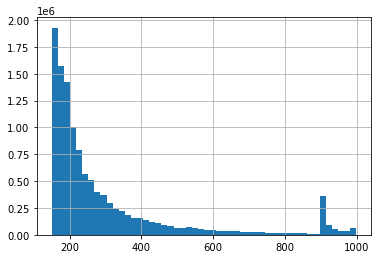

In [59]:
string_df.combined_score.hist(bins=50)

In [60]:
string_df.loc[string_df.combined_score >= 900].head()

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,A_taxid,A_protid,B_taxid,B_protid,A_gene_id,prot_id_x,B_gene_id,prot_id_y
15,9606.ENSP00000000233,9606.ENSP00000432568,0,0,0,62,63,900,94,909,9606,ENSP00000000233,9606,ENSP00000432568,ENSG00000004059,ENSP00000000233,ENSG00000173898,ENSP00000432568
16,9606.ENSP00000000233,9606.ENSP00000427900,0,0,0,0,131,900,56,910,9606,ENSP00000000233,9606,ENSP00000427900,ENSG00000004059,ENSP00000000233,ENSG00000197892,ENSP00000427900
40,9606.ENSP00000000233,9606.ENSP00000354878,0,0,0,0,131,900,56,910,9606,ENSP00000000233,9606,ENSP00000354878,ENSG00000004059,ENSP00000000233,ENSG00000139116,ENSP00000354878
52,9606.ENSP00000000233,9606.ENSP00000405926,0,0,0,63,0,900,80,906,9606,ENSP00000000233,9606,ENSP00000405926,ENSG00000004059,ENSP00000000233,ENSG00000134970,ENSP00000405926
78,9606.ENSP00000000233,9606.ENSP00000314615,0,0,0,82,262,900,624,971,9606,ENSP00000000233,9606,ENSP00000314615,ENSG00000004059,ENSP00000000233,ENSG00000101199,ENSP00000314615


In [62]:
string_df.database.value_counts()

0      11053014
900      604362
600       30592
540       17986
650       17972
800       16150
720        9772
360        9606
Name: database, dtype: int64

In [81]:
string_df.replace(0, np.nan)[['neighborhood','fusion','cooccurence','coexpression','experimental']].describe(exclude=['np.nan'])


TypeError: data type 'np.nan' not understood

In [77]:
string_df.head().replace(0, np.nan)

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,A_taxid,A_protid,B_taxid,B_protid,A_gene_id,prot_id_x,B_gene_id,prot_id_y
0,9606.ENSP00000000233,9606.ENSP00000272298,NaN,NaN,332.0,62.0,181,NaN,125.0,490,9606,ENSP00000000233,9606,ENSP00000272298,ENSG00000004059,ENSP00000000233,ENSG00000143933,ENSP00000272298
1,9606.ENSP00000000233,9606.ENSP00000253401,NaN,NaN,NaN,NaN,186,NaN,56.0,198,9606,ENSP00000000233,9606,ENSP00000253401,ENSG00000004059,ENSP00000000233,ENSG00000131089,ENSP00000253401
2,9606.ENSP00000000233,9606.ENSP00000401445,NaN,NaN,NaN,NaN,159,NaN,NaN,159,9606,ENSP00000000233,9606,ENSP00000401445,ENSG00000004059,ENSP00000000233,ENSG00000178607,ENSP00000401445
3,9606.ENSP00000000233,9606.ENSP00000418915,NaN,NaN,NaN,61.0,158,NaN,542.0,606,9606,ENSP00000000233,9606,ENSP00000418915,ENSG00000004059,ENSP00000000233,ENSG00000147889,ENSP00000418915
4,9606.ENSP00000000233,9606.ENSP00000327801,NaN,NaN,NaN,88.0,78,NaN,89.0,167,9606,ENSP00000000233,9606,ENSP00000327801,ENSG00000004059,ENSP00000000233,ENSG00000185624,ENSP00000327801


In [118]:
import numpy as np
A = [0, 1, 4, 2, 3, 7, 5, 6, 9, 12, 13, 8, 11, 14, 10]
B = [3, 3, 5, 3, 1]

position = 0 
sliced = []
for step in B:
    sliced.append(A[position:step+position])
    position += step
    
sliced

[[0, 1, 4], [2, 3, 7], [5, 6, 9, 12, 13], [8, 11, 14], [10]]

In [94]:
slicer = lambda x,y: A[x:y]

In [113]:
A[2:3]

array([4])

In [114]:
A

array([ 0,  1,  4,  2,  3,  7,  5,  6,  9, 12, 13,  8, 11, 14, 10])